# Dependencies

In [1]:
import os
import copy
import pandas as pd
import numpy as np
import netCDF4 as nc
import sys
import xarray as xr
import scipy as sp
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import NearestNDInterpolator
import tqdm
import glob
import time
from xrft import xrft
import subprocess
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import palettable
from moarpalettes import get_palette

## matplotlib rcParams
## IF you want to use thesis style

import requests
from io import StringIO, BytesIO

req = requests.get('https://raw.githubusercontent.com/njleach/Thesis/main/ancil/figure-style.mplstyle')

with open("/home/l/leach/thesis.mplstyle", "w") as text_file:
    text_file.write(req.content.decode())
    
plt.style.use("/home/l/leach/thesis.mplstyle")
textwidth = matplotlib.rcParams['figure.figsize'][0]

# FUNCTIONS

In [18]:
def fourier_truncate(ds,truncate=0.3):
    
    """
    Spectral truncation of data using FT.
    
    truncate = truncation level in maximum allowed frequency per degree
    """
    
    ds_fft = xrft.fft(ds,dim=['latitude','longitude'],true_phase=True,true_amplitude=True)

    # truncate
    ds_fft = ds_fft.where(np.sqrt(ds_fft.freq_longitude**2+ds_fft.freq_latitude**2)<0.3,0)

    # invert
    ds_ifft = xrft.ifft(ds_fft,dim=['freq_longitude','freq_latitude'],true_phase=True,true_amplitude=True)

    return ds_ifft

def truncate_and_save(fpath,add_msl=True):
    
    ds = xr.open_dataset(fpath)
    ds = ds.vo.sel(level=850,time=(ds.time.dt.hour%3)==0)
    ds = ds.sel(time=slice('2022-02-10','2022-02-22'))
    ds_trunc = fourier_truncate(ds).sortby('latitude',ascending=False)
    
    if add_msl:
        ds = xr.open_dataset(fpath.replace('/pl/','/sfc/')).get(['msl'])
        ds = ds.sel(time=ds_trunc.time)
        ds['vo'] = (('time','latitude','longitude'),ds_trunc.real.values)
        ds.to_netcdf('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TE_in.nc')
    else:
        ds_trunc.real.to_netcdf('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TE_in.nc')
        
def run_TE(fpath):
    
    truncate_and_save(fpath)

    DetectNodes_args = []
    DetectNodes_args += ['DetectNodes']

    DetectNodes_args += ['--in_data','/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TE_in.nc']
    DetectNodes_args += ['--out','/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TENodes']
    DetectNodes_args += ['--closedcontourcmd','msl,200,5.0,0']
    DetectNodes_args += ['--mergedist','6.0']
    DetectNodes_args += ['--searchbymax','vo']
    DetectNodes_args += ['--outputcmd','msl,min,3']
    DetectNodes_args += ['--timefilter','3hr']
    DetectNodes_args += ['--latname','latitude']
    DetectNodes_args += ['--lonname','longitude']
    DetectNodes_args += ['--regional']

    StitchNodes_args = []
    StitchNodes_args += ['StitchNodes']

    StitchNodes_args += ['--in_fmt','lon,lat,slp']
    StitchNodes_args += ['--in','/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TENodes']
    StitchNodes_args += ['--out','/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch']
    StitchNodes_args += ['--range','5.0']
    StitchNodes_args += ['--mintime','24h']
    StitchNodes_args += ['--maxgap','6h']
    StitchNodes_args += ['--min_endpoint_dist','10.0']
    StitchNodes_args += ['--out_file_format','csv']
    
    DN_out = subprocess.run(DetectNodes_args,stdout=subprocess.PIPE)
    SN_out = subprocess.run(StitchNodes_args,stdout=subprocess.PIPE)
    
def read_nodes(fpath):
    
    with open(fpath,'r') as f:
        lines = f.readlines()

    readout = []
    for line in lines:

        if line[:1] != '\t':
            year,mon,day,num,hr = line.replace('\n','').split('\t')
            date = pd.to_datetime('{:04d}-{:02d}-{:02d} {:02d}'.format(int(year),int(mon),int(day),int(hr)))
        else:
            _,idxlon,idxlat,lon,lat,p_min = line.replace('\n','').split('\t')
            readout += [[float(lon),float(lat),float(p_min),date]]
            
    return pd.DataFrame(data=readout,columns=['lon','lat','p_min','date'])

# IMPORT DATA

In [25]:
fpath = '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/pl/cf/1_2022-02-16.nc'

# Run TE

In [26]:
field_in.close()

run_TE(fpath)

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/xrft/xrft.py:556: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


In [27]:
tracks_out = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch',skipinitialspace=True)
tracks_out['date'] = pd.to_datetime(tracks_out[['year','month','day','hour']])

nodes_out = read_nodes('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TENodes')

field_in = xr.open_dataset('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TE_in.nc')

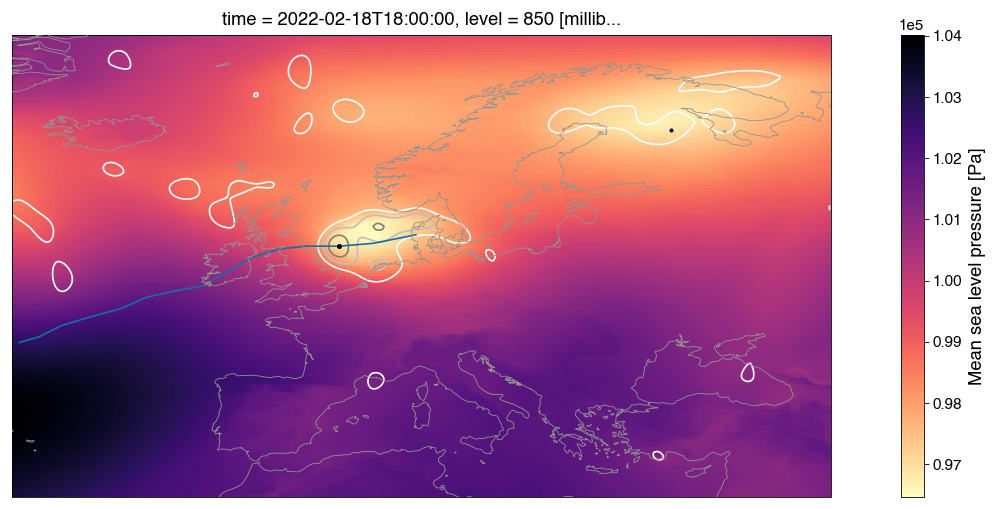

In [28]:
fig,ax = plt.subplots(subplot_kw=dict(projection=crs.PlateCarree()),figsize=(15,5))

choose_time='2022-02-18 18'

# test_truncate.sel(time=choose_time).real.plot(ax=ax)
field_in.sel(time=choose_time).msl.plot(ax=ax,cmap='magma_r')
field_in.sel(time=choose_time).vo.plot.contour(ax=ax,levels=[1e-4,2e-4,3e-4,4e-4,5e-4],cmap='binary')

nodes_out.loc[nodes_out.date==choose_time].plot.scatter('lon','lat',color='k',s=2,ax=ax)

tracks_out.loc[tracks_out.date==choose_time,['lon','lat']].plot.scatter('lon','lat',ax=ax,color='k',s=4,zorder=10)

g=sn.lineplot(data=tracks_out.loc[(tracks_out.date>'2022-02-17')&(tracks_out.date<'2022-02-20')],x='lon',y='lat',hue='track_id',legend=False,ax=ax,estimator=None,zorder=9,sort=False)

ax.coastlines(color='xkcd:grey',lw=0.5,zorder=10)